# Модель для прогнозирования рыночной стоимости автомобиля

**Описание:**  
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

**Задача:** Разработать модель для прогнозирования рыночной стоимости автомобиля  

**Основные требования заказчика:**  
 * качество предсказания по RMSE должно быть меньше 2500;  
 * скорость предсказания;  
 * время обучения.  
 
**План действий:**  
 1. Загрузить данные.
 2. Изучить данные. Обработать пропущенные значения и аномалии, неинформативные признаки - удалить.
 3. Подготовить выборки для обучения моделей.
 4. Обучим разные модели, одна из которых — LightGBM и как минимум одна — не бустинг. Попробуем разные гиперпараметры.
 5. Проанализируем время обучения, время предсказания и качество моделей.
 6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.


**Признаки:**  
*DateCrawled* — дата скачивания анкеты из базы  
*VehicleType* — тип автомобильного кузова  
*RegistrationYear* — год регистрации автомобиля  
*Gearbox* — тип коробки передач  
*Power* — мощность (л. с.)  
*Model* — модель автомобиля  
*Kilometer* — пробег (км)  
*RegistrationMonth* — месяц регистрации автомобиля  
*FuelType* — тип топлива  
*Brand* — марка автомобиля  
*Repaired* — была машина в ремонте или нет  
*DateCreated* — дата создания анкеты  
*NumberOfPictures* — количество фотографий автомобиля  
*PostalCode* — почтовый индекс владельца анкеты (пользователя)  
*LastSeen* — дата последней активности пользователя  
  
**Целевой признак**  
*Price* — цена (евро)

## Подготовка данных

### Загрузим данные.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm
from scipy.stats import spearmanr

Загрузим данные и посмотрим что внутри датасета

In [27]:
df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'LastSeen', 'DateCreated'])

In [28]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Фиксируем размероность датасета

In [29]:
df_first = df.shape
df_first

(354369, 16)

### Изучим данные. 

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Типы данных привоены верно. Названия столбцов не соответствует стандарту, но менять его не буду т.к. так будет удобно для чтения.

**Проверим дубликаты**

Явные дубликаты:

In [31]:
df.duplicated().sum()

4

In [32]:
df = df.drop_duplicates()

In [33]:
df.duplicated().sum()

0

Неявные дубликаты:

In [34]:
df[df[['DateCrawled','Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model','Kilometer','RegistrationMonth',
       'FuelType','Brand','Repaired','DateCreated','NumberOfPictures','PostalCode','LastSeen']].duplicated(keep=False)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


**Смотрим пропуски.**

In [37]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [38]:
((df.isna().sum()/ df.isna().count())*100).round()

DateCrawled           0.0
Price                 0.0
VehicleType          11.0
RegistrationYear      0.0
Gearbox               6.0
Power                 0.0
Model                 6.0
Kilometer             0.0
RegistrationMonth     0.0
FuelType              9.0
Brand                 0.0
Repaired             20.0
DateCreated           0.0
NumberOfPictures      0.0
PostalCode            0.0
LastSeen              0.0
dtype: float64

**Пропуски присутствуют только в 5 столбцах, но их достаточно много от 6% до 20%.**

Будем рассматривать каждый столбец в отдельности на пропуски, аномалии и необходимость для модели прогнозирования.

---

### Обработаем пропущенные значения и аномалии.

*Price* — цена (евро)

In [39]:
df['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

<AxesSubplot:title={'center':'Price'}, ylabel='Frequency'>

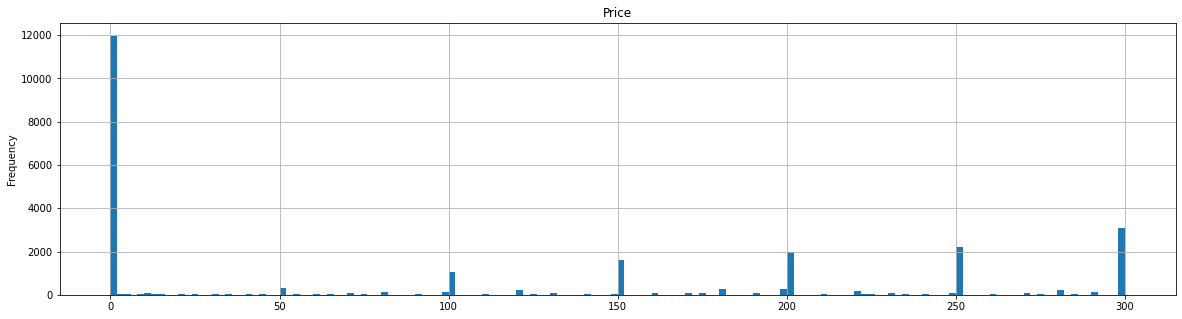

In [40]:
df['Price'].plot(kind = 'hist', range=(0,300), bins = 150, title = 'Price',grid = True, figsize=(20,5))

In [41]:
df['Price'].value_counts(normalize= True)

Price
0       0.030398
500     0.016000
1500    0.015222
1000    0.013116
1200    0.012964
          ...   
1294    0.000003
2511    0.000003
5775    0.000003
7428    0.000003
7070    0.000003
Name: proportion, Length: 3731, dtype: float64

**Количество нулей в столбце цены составлет самую большую групу, в общем объеме 3%. Выделим отдельно строки с 0.**

In [42]:
p = df[df['Price'] == 0]
p.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11,0,27432,2016-03-12 23:47:10


In [43]:
p.groupby('DateCreated')['DateCrawled'].first()

DateCreated
2016-01-26   2016-03-06 01:47:42
2016-02-07   2016-03-07 20:44:49
2016-02-09   2016-03-07 09:58:38
2016-02-12   2016-03-06 00:53:53
2016-02-18   2016-03-06 00:58:57
2016-02-29   2016-03-05 14:47:15
2016-03-02   2016-03-08 08:28:19
2016-03-03   2016-03-05 14:12:21
2016-03-04   2016-03-05 14:23:21
2016-03-05   2016-03-05 14:43:47
2016-03-06   2016-03-06 10:06:20
2016-03-07   2016-03-07 15:06:23
2016-03-08   2016-03-08 14:38:34
2016-03-09   2016-03-09 08:53:31
2016-03-10   2016-03-10 22:25:34
2016-03-11   2016-03-11 18:55:53
2016-03-12   2016-03-12 11:53:24
2016-03-13   2016-03-13 07:36:57
2016-03-14   2016-03-14 18:40:14
2016-03-15   2016-03-15 21:48:31
2016-03-16   2016-03-16 22:06:24
2016-03-17   2016-03-17 22:38:13
2016-03-18   2016-03-18 08:37:21
2016-03-19   2016-03-19 18:40:12
2016-03-20   2016-03-20 18:53:27
2016-03-21   2016-03-21 18:54:38
2016-03-22   2016-03-22 16:37:59
2016-03-23   2016-03-23 17:55:19
2016-03-24   2016-03-24 10:58:40
2016-03-25   2016-03-25 22:53:4

In [44]:
del p

Все анкеты с "0" в столбце цена имеют одно время создания 00:00:00. И в большенстве случаев в туже дату что были скачены анкеты из базы. Данные особенности создают угрозу что аннкеты с "0" искуственные и это может исказить работу модели. К тому же цена является целевым признаком, а наличие нулей в наборе данных повлияет на качество предсказания. Востановить данные нет возможности. Поэтому удалю строки с ценой равной "0" евро.

In [45]:
df = df[df['Price'] > 1]
df['Price'].describe()

count    342404.000000
mean       4570.961668
std        4514.912239
min           2.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

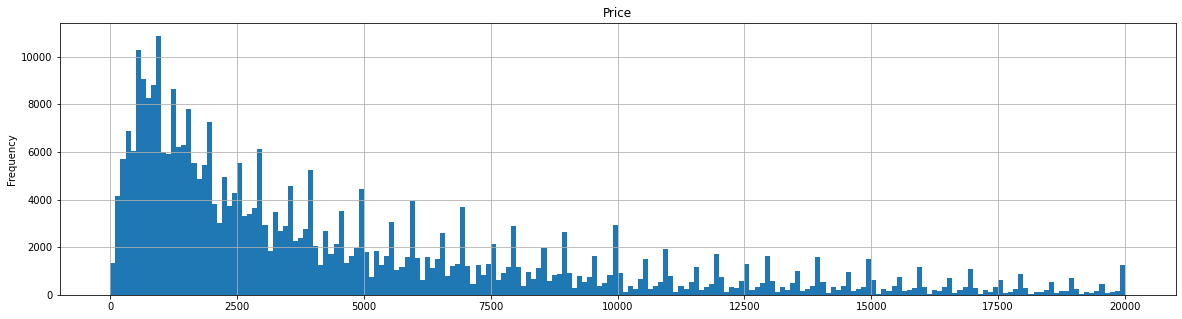

In [46]:
df['Price'].plot(kind = 'hist', range=(0,20000), bins = 200, title = 'Price',grid = True, figsize=(20,5))
plt.show()

---

*DateCrawled* — дата скачивания анкеты из базы

Данные выгружены за один месяц 2016г, примерно равномерно за этот период.  
Никакой пользы для модели данная инофрмация не несет, поэтому чтобы не перегружать расчеты, удалю столбец при подготовке данных к обучению.

Начало: 2016-03-05 14:06:22
Конец: 2016-04-07 14:36:58


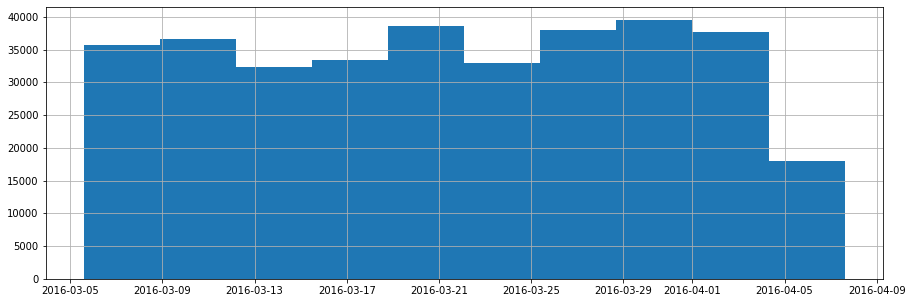

In [47]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['DateCrawled'].hist(figsize = (15, 5), grid = True)
print('Начало:', df['DateCrawled'].min())
print('Конец:', df['DateCrawled'].max())

------

*VehicleType* — тип автомобильного кузова

Типы кузова указаны корректно. Однако большое количество пропусков - 9,7%. 
Маловероятно чтобы владелец машины не знал какой у нее кузов, при этом для случайного пропуска, объем почти в 10% слишком велик.
Определим тип кузова по Модели авто, там где по модели сопоставить не получиться, присвою пропускам категорию "other". 

In [48]:
print(df['VehicleType'].value_counts(normalize= True))
print()
print('Пропуски:', df['VehicleType'].isna().sum() / df['VehicleType'].isna().count())

VehicleType
sedan          0.288585
small          0.251829
wagon          0.205585
bus            0.091495
convertible    0.064143
coupe          0.050388
suv            0.038072
other          0.009902
Name: proportion, dtype: float64

Пропуски: 0.09720096727841965


In [49]:
df['VehicleType'] = df['VehicleType'].fillna(df.groupby('Model')['VehicleType'].transform('first'))
df['VehicleType'] = df['VehicleType'].fillna('other')
print(df['VehicleType'].value_counts(normalize= True))
print()
print('Пропуски:', df['VehicleType'].isna().sum() / df['VehicleType'].isna().count())

VehicleType
sedan          0.279135
small          0.260429
wagon          0.199869
bus            0.092274
convertible    0.060975
coupe          0.046594
suv            0.035554
other          0.025169
Name: proportion, dtype: float64

Пропуски: 0.0


---

*RegistrationYear* — год регистрации автомобиля

Не совсем понятно, что имеется ввиду в данном параметре: год выпуска авто или когда владелец именно зарегистрировал его на себя. При этом очень большой разброс годов регистрации, некоторые прям совсем фантастические. Судя по графикам и согласно здравого смысла машины не могут быть зарегистированны ранее 1960 года и позже апреля 2016.  
Исходя из названия сервиса по продаже автомобилей с пробегом «Не бит, не крашен» территориально он должен находиться в России.
Согласно историческим данным в 1946 была проведена реформа регистрационных знаков, требующая обязательной перерегистрации всех автомобилей, поэтому данные за более ранний период недействительны.
Т.к. выгрузка у нас за март-апрель 2016г. более поздних анкет не должны быть в данных.  
Скореткировать их нет возможности, удалим данные выходящие за пределы временного отрезка от 1946 до 2016 года.

In [650]:
np.unique(df['RegistrationYear'])

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800,
       8000, 8200, 8500, 8888, 9000, 9450, 9999])

Text(0, 0.5, 'Количество')

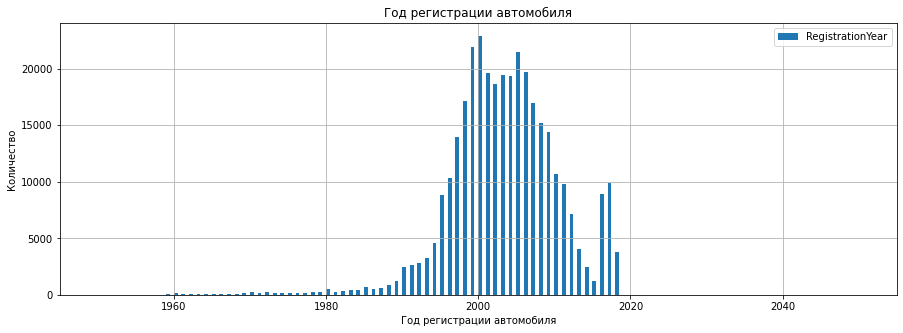

In [651]:
df.plot(y = 'RegistrationYear', kind = 'hist', bins = 200, range=(1950,2050), figsize = (15, 5), 
          title = 'Год регистрации автомобиля', grid = True)
plt.xlabel("Год регистрации автомобиля")
plt.ylabel("Количество")

In [652]:
df = df[df['RegistrationYear'] > 1945]
df = df[df['RegistrationYear'] < 2017]
np.unique(df['RegistrationYear'])

array([1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016])

---

*Gearbox* — тип коробки передач

В данных представлены только две возможые вариации коробок передач, скоре всего пропуски, это авто с роботизированной или вариативной коробками передеч. Поэтому заменим пропуски на "other".

In [653]:
print(df['Gearbox'].value_counts(normalize= True))
print()
print('Пропуски:', df['Gearbox'].isna().sum() / df['Gearbox'].isna().count())

manual    0.799404
auto      0.200596
Name: Gearbox, dtype: float64

Пропуски: 0.04627513050359931


In [654]:
df['Gearbox'] = df['Gearbox'].fillna('other')
print(df['Gearbox'].value_counts(normalize= True))
print()
print('Пропуски:', df['Gearbox'].isna().sum() / df['Gearbox'].isna().count())

manual    0.762412
auto      0.191313
other     0.046275
Name: Gearbox, dtype: float64

Пропуски: 0.0


---

*Power* — мощность (л. с.)

Соглано данным 9,8% строк не содержат данных о мощности, т.е. указанная мощность равна "0", при этом пропусков в данных нет. 
Данный объем слишком большой чтобы его удалять, поэтому предлагаю заменить "0" средними значениями для моделей автомобилей.
Согласно изучению рынка автомобилей мощность варьируется от 5 до 3000 лошадинных сил. В среднем машины обладают мощность от 30 до 300 л.с.

0       0.098434
75      0.067210
60      0.044875
150     0.041703
101     0.037716
          ...   
428     0.000003
6062    0.000003
685     0.000003
1799    0.000003
903     0.000003
Name: Power, Length: 683, dtype: float64

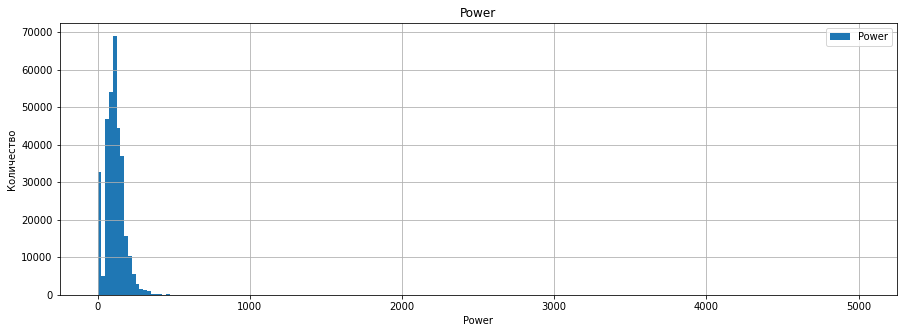

In [655]:
df.plot(y = 'Power', kind = 'hist', bins = 200, figsize = (15, 5), 
          title = 'Power', grid = True, range=(0,5000))
plt.xlabel("Power")
plt.ylabel("Количество")
df['Power'].value_counts(normalize= True)

In [656]:
df.loc[(df['Power'] > 3000) | (df['Power'] <= 5), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('mean'))
df['Power'] = df['Power'].fillna(df.groupby('Brand')['Power'].transform('mean'))

In [657]:
print(df['Power'].describe())
print()
print('Пропуски:', df['Power'].isna().sum() / df['Power'].isna().count())

count    328535.000000
mean        121.027763
std          63.818011
min           6.000000
25%          77.000000
50%         111.000000
75%         150.000000
max        2799.000000
Name: Power, dtype: float64

Пропуски: 0.0


---

*Brand* — марка автомобиля

В столбце Бренд нет пропусков, названия брендов отражены корректно. Названия брендов 'land_rover' и  'rover' - синонимы, поэтому объединю значения под брендом 'land_rover'.

In [658]:
sorted(df['Brand'].unique(), key=str)

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

In [659]:
df['Brand'] = df['Brand'].replace('rover', 'land_rover')

In [660]:
sorted(df['Brand'].unique(), key=str)

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

---

*Model* — модель автомобиля

Названия моделей отражены корректно. Названия моделей 'range_rover' и  'rangerover' - синонимы, поэтому объединю значения под маркой 'range_rover'.  
В столбце Модель 4,6% пропусков, заменю их на "other", данная категория уже есть в данных по некоторым брендам. 

In [661]:
print('Пропуски:', df['Model'].isna().sum() / df['Model'].isna().count())

Пропуски: 0.04673779049416348


In [662]:
sorted(df['Model'].unique(), key=str)

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [663]:
df['Model'] = df['Model'].replace('rangerover', 'range_rover')

In [664]:
df['Model'] = df['Model'].fillna("other")

In [665]:
sorted(df['Model'].unique(), key=str)

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [666]:
print('Пропуски:', df['Model'].isna().sum() / df['Model'].isna().count())

Пропуски: 0.0


---

*Kilometer* — пробег (км)

В данном столбце пропусков нет. Распределение не соответствует нормальному, но соответствует ожиданиям для объявлений о продаже подержагнных машин: большинство авто с пробегом более 125 тыс.км.

In [667]:
print(df['Kilometer'].describe())
print()
print('Пропуски:', df['Kilometer'].isna().sum() / df['Kilometer'].isna().count())

count    328535.000000
mean     128267.323116
std       37410.718568
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Пропуски: 0.0


<AxesSubplot:>

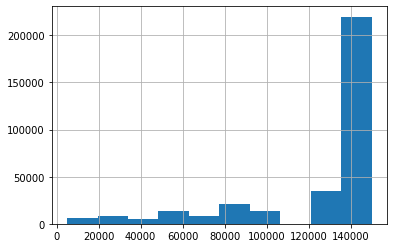

In [668]:
df['Kilometer'].hist()

---

*RegistrationMonth* — месяц регистрации автомобиля

В данном столбце пропусков нет. Распределение распологается в диапозоне от 1 до 12.  
Для построения модели, данная информация не нужна, поэтому при подготове данных к обучению, удалю этот столбец.

<AxesSubplot:>

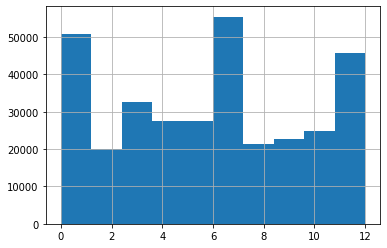

In [669]:
df['RegistrationMonth'].hist()

In [670]:
df['RegistrationMonth'] = df['RegistrationMonth'].replace( 0, 'unknown')

In [671]:
df['RegistrationMonth'].unique()

array(['unknown', 5, 8, 6, 7, 10, 12, 11, 2, 3, 1, 4, 9], dtype=object)

---

*FuelType* — тип топлива

В данном столбце пропуски составляют 7,2%. 
Предполагается, что есть зависимость между моделью и типом топлива которое рекомедует производитель, поэтому заменим пропуски на тип топлива по таким же моделям.

In [672]:
print(df['FuelType'].value_counts(normalize= True))
print()
print('NaN:', df['FuelType'].isna().sum() / df['FuelType'].isna().count())

petrol      0.669675
gasoline    0.310621
lpg         0.016443
cng         0.001742
hybrid      0.000718
other       0.000518
electric    0.000282
Name: FuelType, dtype: float64

NaN: 0.0721901776066477


In [673]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform('first'))

In [674]:
df['FuelType'] = df['FuelType'].replace('petrol', 'gasoline')

In [675]:
print(df['FuelType'].value_counts(normalize= True))
print()
print('NaN:', df['FuelType'].isna().sum() / df['FuelType'].isna().count())

gasoline    0.981259
lpg         0.015688
cng         0.001616
hybrid      0.000667
other       0.000508
electric    0.000262
Name: FuelType, dtype: float64

NaN: 0.0


---

*Repaired* — была машина в ремонте или нет

В данном столбце пропуски составляют 18%. 
Если владелец авто пытается cкрыть факт ремонта, проверить это достаточно сложно, даже когда физически видешь машину. Поэтому предположим что все пропуски, это машины которые не были в ремонте.

In [676]:
print(df['Repaired'].value_counts(normalize= True))
print()
print('NaN:', df['Repaired'].isna().sum() / df['Repaired'].isna().count())

no     0.878532
yes    0.121468
Name: Repaired, dtype: float64

NaN: 0.18026085500783784


In [677]:
df['Repaired'] = df['Repaired'].fillna('unknown')

In [678]:
print(df['Repaired'].value_counts(normalize= True))
print()
print('Пропуски:', df['Repaired'].isna().sum() / df['Repaired'].isna().count())

no         0.720167
unknown    0.180261
yes        0.099572
Name: Repaired, dtype: float64

Пропуски: 0.0


---

*DateCreated* — дата создания анкеты

Анкеты представленные в датасете созданы за период с марта 2014г. по апрель 2016г. Основной объем взят за 2016г - это хорошо т.к. цены на авто меняются и для лучшего прогнозирования лучше опираться на ближайшие данные. 
Так как никакой пользы для прогнозирования данная иноформация не несет, удалю данный столбец при подготовке данных к обучению.

Начало: 2014-03-10 00:00:00
Конец: 2016-04-07 00:00:00


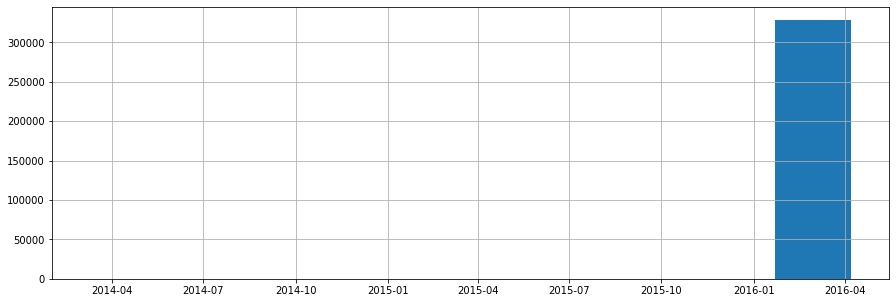

In [679]:
df['DateCreated'].hist(figsize = (15, 5), grid = True)
print('Начало:', df['DateCreated'].min())
print('Конец:', df['DateCreated'].max())

---

*NumberOfPictures* — количество фотографий автомобиля

Странно, что нет ни одной фотографии, но так как ниличие фото нам никак не поможет в прогнозе цены, удалю данный столбец при подготовке данных к обучению.

In [680]:
df['NumberOfPictures'].describe()

count    328535.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

---

*PostalCode* — почтовый индекс владельца анкеты (пользователя)

Индекс излишняя информация для прогноза цены, удалю данный столбец при подготовке данных к обучению.

<AxesSubplot:>

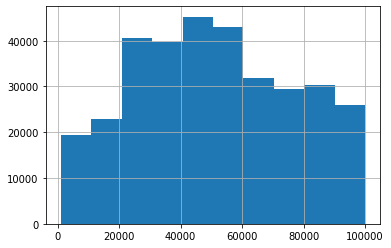

In [681]:
df['PostalCode'].hist()

---

*LastSeen* — дата последней активности пользователя

Все анкеты в выборке были активированы в течении месяца выгрузки данных, значит в выборке нет старых анкеты про которые просто забыли. Т.о. модель будет обучаться на актуальных данных.
Для прогнозирования данная иноформация не нужна, удалю этот столбец при подготовке данных к обучению.

Начало: 2016-03-05 14:15:08
Конец: 2016-04-07 14:58:51


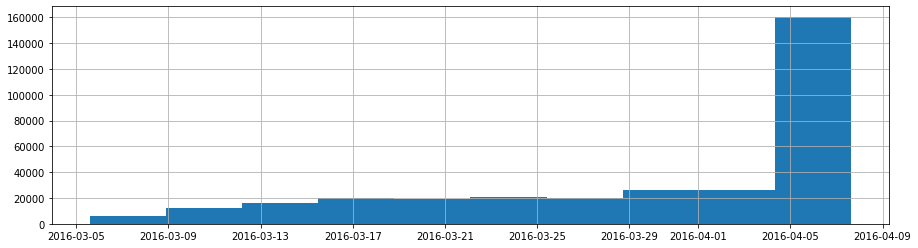

In [682]:
df['LastSeen'].hist(figsize = (15, 4), grid = True)
print('Начало:', df['LastSeen'].min())
print('Конец:', df['LastSeen'].max())

---

**Проверим наличие пропусков и объем сохраненной информации после предобработки:**

In [683]:
print('Размерность датасета после предобработки:', df.shape)
print('Сохраненный объем изначального датасета:', df.shape[0] / df_first[0])

Размерность датасета после предобработки: (328535, 16)
Сохраненный объем изначального датасета: 0.9270985893235583


In [684]:
((df.isna().sum()/ df.isna().count())*100).round()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

---

**Вывод подраздела:**  
Проведена следующая предобработка:  

- Изначальный датасет содержал 354 369 строк и 16 столбцов, типы данных по столбцам присвоены корректно. 
- Стиль наименования столбцов не меняла, т.к. в названии слиты несколько слов и при существующем стиле так удобнее.
- Выявленные явные и неявные дубликаты в небольшом объеме удалены.  
- Удалены строки с нулевым целевым признаком по столбцу Price, а также строки  по столбцу RegistrationYear с датой регистрации автомобиля  за пределами периода с 1946 по 2016 года.  
- Пропуски выявлены в 5 столбцах:  VehicleType, Gearbox, Model, FuelType  и Repaired.
  - В VehicleType, пропуски были заменены по типу кузова такой же модели, если сопоставление сделать было невозможно, производилась замена на  'other'.
  - В Gearbox, пропуски были заменены на 'other' т.к. в датасете присутствовало только два вида коробки передач.
  - В Model, пропуски были заменены на 'other', т.к. Сопоставить модели по другим признаком не представлеяется возможным. Синонимы  'range_rover' и 'rangerover' были объединены под маркой 'range_rover'. 
  - В FuelType, пропуски были скорректированы по типу топлива такой же модели. Так как названия топлива 'petrol' и 'gasoline' это одно и тоже, были объеденены под типом 'gasoline'.
  - В Repaired, пропуски были заменены на “unknown”, т.к. подтвердить факт ремонта нет возможности.  
  
- В Power присутствовали строки с “0” мощностью, была произведена корректировка в соответствии с  аналогичной мощностью по такое же Модели или Бренду.
- В Brand  синонимы 'land_rover' и 'rover' были объединены под брендом 'land_rover'.
- Kilometer - пропусков нет, большинство моделей с пробегом более 125 тыс.км.
- RegistrationMonth - строки с “0” заменены на “unknown”.
- DateCreated — большинство анкет которые включены в датасет были созданы в 2016г.
- NumberOfPictures  - фотографии не предоставлены
- PostalCode -  пропусков и аномалий нет. 
- LastSeen -  пропусков и аномалий нет.  Все анкеты датасета были активированы в течении месяца выгрузки данных в 2016г.
  
**По итогу преобразований обработаны все пропуски и аномалии. Сохраненный объем изначального датасета 92,7%.**  


Для ускорения работы модели, в следующем разделе удалим столбцы с признаками которые никаким образом не повлияют на прогнозирование целевого признака, а лишь усложнять расчеты:
- DateCrawled 
- RegistrationMonth 
- DateCreated 
- NumberOfPictures 
- PostalCode 
- LastSeen 

### Подготовка данных к обучению

**Согласно выводам предобработки удаляю столбцы с признаками не нужными для обучения модели.**

In [685]:
df = df.drop(['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,small,1993,manual,105.267137,golf,150000,gasoline,volkswagen,unknown
1,18300,coupe,2011,manual,190.000000,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.000000,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75.000000,golf,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69.000000,fabia,90000,gasoline,skoda,no


---

**Проведем проверку на мультиколлинеарности, т.к будем использовать линейную регрессию.**

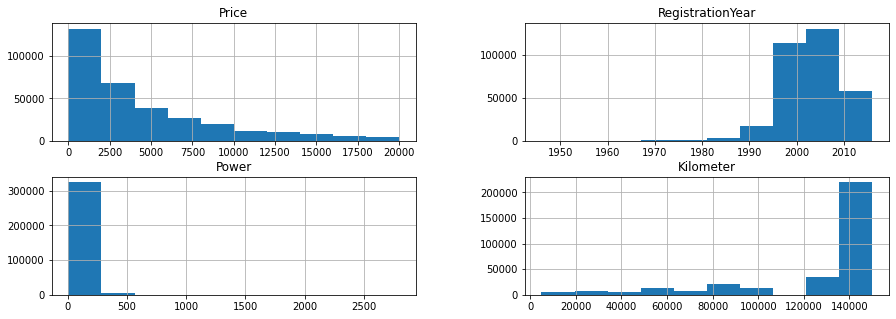

In [686]:
df.hist(figsize = (15, 5), grid = True)
plt.show()

In [687]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.449365,0.406181,-0.357095
RegistrationYear,0.449365,1.000000,0.096107,-0.234739
Power,0.406181,0.096107,1.000000,0.080185
Kilometer,-0.357095,-0.234739,0.080185,1.000000


Согласно коэффициента корреляции Пирсона, можно сказать что между числовиыми признаками наблюдается незачительная корреляция, как положительная так и отрицательная.

Так как данные в столбцах распределены не нормально, используем корреляцию Спирмена.

In [688]:
print('Корреляцию Спирмена между "Price" и "Power":', spearmanr(df["Price"], df["Power"]))
print('Корреляцию Спирмена между "Price" и "Kilometer":', spearmanr(df["Price"], df["Kilometer"]))
print('Корреляцию Спирмена между "Price" и "RegistrationYear":', spearmanr(df["Price"], df["RegistrationYear"]))

Корреляцию Спирмена между "Price" и "Power": SpearmanrResult(correlation=0.5005242012758986, pvalue=0.0)
Корреляцию Спирмена между "Price" и "Kilometer": SpearmanrResult(correlation=-0.3404768045149033, pvalue=0.0)
Корреляцию Спирмена между "Price" и "RegistrationYear": SpearmanrResult(correlation=0.6338916864493388, pvalue=0.0)


Соглано расчетам, между числовими признаками имеется некоторая положительная корреляция.

**Исходя из полученных данных о корреляции нельзя сказать, что ее уровень настолько высок чтобы оказать значительно влияние на качестово работы модели Линейной регрессии.**

---

**Используем прямое кодирование для преобразования категориальных признаков в численные последством OHE.**

In [689]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
0,480,1993,105.267137,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190.000000,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.000000,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.000000,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69.000000,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,2000,127.768800,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354365,2200,2005,159.151373,20000,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
354366,1199,2000,101.000000,125000,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,1996,102.000000,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Фиксируем размерность нового датасета

In [690]:
df_ohe_first = df_ohe.shape
df_ohe_first

(328535, 306)

**Произведем разделение датафрейма на признаки и целевой признак, а также на тренировочную, валидационную и тестовые выборки.**

In [691]:
target = df_ohe['Price']
features = df_ohe.drop('Price', axis=1)

features_train, features_tv, target_train, target_tv = train_test_split(
    features, target, test_size=0.4, random_state=1234567)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_tv, target_tv, test_size=0.5, random_state=1234567)

**Проведем масштабирование признаков**

In [692]:
numeric = ['Power', 'Kilometer', 'RegistrationYear']

pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Проверим размерность разделенных выборок.**

In [693]:
print('Размерность features_train:', features_train.shape)
print('Размерность   target_train:', target_train.shape)

print('Размерность features_valid:', features_valid.shape)
print('Размерность   target_valid:', target_valid.shape)

print('Размерность  features_test:', features_test.shape)
print('Размерность    target_test:', target_test.shape)


print('Доля train:', features_train.shape[0] / df_ohe_first[0])
print('Доля valid:', features_valid.shape[0] / df_ohe_first[0])
print('Доля  test:', features_test.shape[0] / df_ohe_first[0])

Размерность features_train: (197121, 305)
Размерность   target_train: (197121,)
Размерность features_valid: (65707, 305)
Размерность   target_valid: (65707,)
Размерность  features_test: (65707, 305)
Размерность    target_test: (65707,)
Доля train: 0.6
Доля valid: 0.2
Доля  test: 0.2


**Вывод: Данные готовы к обучению моделей.**

## Обучение моделей

Проведем обучсение 3 моделей: Линейная регрессия, Дерево Решений и  LightGBM.  
Время будем замерять через команду `%%time`.  
**Целевой показатель RMSE меньше 2500**.

### Линейная регрессия

In [694]:
%%time
model_lr = LinearRegression(fit_intercept=False, normalize = False)
model_lr.fit(features_train, target_train)

CPU times: user 12.5 s, sys: 4.03 s, total: 16.5 s
Wall time: 16.4 s


LinearRegression(fit_intercept=False)

In [695]:
%%time
predictions_lr = model_lr.predict(features_valid)
rmse_lr = mean_squared_error(target_valid, predictions_lr)**0.5
print('Метрика RMSE по модели Линейной регрессии на валидационной выборке:', rmse_lr.round(2))

Метрика RMSE по модели Линейной регрессии на валидационной выборке: 2840.57
CPU times: user 87.2 ms, sys: 115 ms, total: 202 ms
Wall time: 196 ms


### Дерево Решений

Подбираем параметры:

In [696]:
best_rmse_dtr = 2500 
best_depth = 0
for depth in range(1, 21):
    model_dtr = DecisionTreeRegressor(random_state=1234567, max_depth=depth)
    model_dtr.fit(features_train, target_train)
    predictions_dtr = model_dtr.predict(features_valid)
    rmse_dtr = mean_squared_error(target_valid, predictions_dtr)**0.5
    if rmse_dtr < best_rmse_dtr:
            best_rmse_dtr = rmse_dtr
            best_depth = depth
print('Метрика RMSE по модели Дерево Решений:', best_rmse_dtr)
print("Количество ветвей наилучшей модели на валидационной выборке:", best_depth)  

Метрика RMSE по модели Дерево Решений: 1881.472811371966
Количество ветвей наилучшей модели на валидационной выборке: 17


In [697]:
%%time
model_dtr = DecisionTreeRegressor(random_state=1234567, max_depth=17)
model_dtr.fit(features_train, target_train)

CPU times: user 4.47 s, sys: 173 ms, total: 4.64 s
Wall time: 4.65 s


DecisionTreeRegressor(max_depth=17, random_state=1234567)

In [698]:
%%time
predictions_dtr = model_dtr.predict(features_valid)
rmse_dtr = mean_squared_error(target_valid, predictions_dtr)**0.5
print('Метрика RMSE по модели Дерево Решений на валидационной выборке:', rmse_dtr)

Метрика RMSE по модели Дерево Решений на валидационной выборке: 1881.472811371966
CPU times: user 61.3 ms, sys: 58.1 ms, total: 119 ms
Wall time: 126 ms


---

### LightGBM

Для бустинга произведем перекодировку подвыборок.

In [699]:
for col in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']:
    df[col] = df[col].astype('category')

In [701]:
target_gbm = df['Price']
features_gbm = df.drop('Price', axis=1)

features_train_gbm, features_tv_gbm, target_train_gbm, target_tv_gbm = train_test_split(
    features, target, test_size=0.4, random_state=1234567)

features_test_gbm, features_valid_gbm, target_test_gbm, target_valid_gbm = train_test_split(
    features_tv_gbm, target_tv_gbm, test_size=0.5, random_state=1234567)

numeric = ['Power', 'Kilometer', 'RegistrationYear']

scaler.fit(features_train_gbm[numeric])
features_train_gbm[numeric] = scaler.transform(features_train_gbm[numeric])
features_valid_gbm[numeric] = scaler.transform(features_valid_gbm[numeric])
features_test_gbm[numeric] = scaler.transform(features_test_gbm[numeric])

Подбираем параметры:

In [702]:
%%time
best_rmse_lightgbm = 2500 
best_est_lightgbm = 0
best_depth_lightgbm = 0
best_num_leaves_lightgbm = 0

for est in range(50, 151, 50):
    for depth in range(10, 21, 5):
        for num in range (50, 101, 50):
            model_lightgbm = LGBMRegressor(learning_rate=0.1, num_leaves=num, max_depth = depth, 
                                           n_estimators = est, random_state=1234567)
            model_lightgbm.fit(features_train_gbm, target_train_gbm)
            predictions_lightgbm = model_lightgbm.predict(features_valid_gbm)
            rmse_lightgbm = mean_squared_error(target_valid_gbm, predictions_lightgbm)**0.5
            if rmse_lightgbm < best_rmse_lightgbm:
                best_rmse_lightgbm = rmse_lightgbm
                best_est_lightgbm = est
                best_depth_lightgbm = depth
                best_num_leaves_lightgbm = num
print('Метрика RMSE по модели Дерево Решений:', best_rmse_lightgbm)
print("Количество деревьев наилучшей модели на валидационной выборке:", best_est_lightgbm)  
print("Количество ветвей наилучшей модели на валидационной выборке:", best_depth_lightgbm) 
print("Количество листьев наилучшей модели на валидационной выборке:", best_num_leaves_lightgbm) 

Метрика RMSE по модели Дерево Решений: 1617.5310766692382
Количество деревьев наилучшей модели на валидационной выборке: 150
Количество ветвей наилучшей модели на валидационной выборке: 20
Количество листьев наилучшей модели на валидационной выборке: 100
CPU times: user 2min 43s, sys: 6.15 s, total: 2min 49s
Wall time: 2min 50s


In [703]:
%%time
model_lightgbm = LGBMRegressor(learning_rate=0.1, num_leaves=100, max_depth = 20, n_estimators = 150, random_state=1234567)
model_lightgbm.fit(features_train_gbm, target_train_gbm)

CPU times: user 12.9 s, sys: 275 ms, total: 13.2 s
Wall time: 13.3 s


LGBMRegressor(max_depth=20, n_estimators=150, num_leaves=100,
              random_state=1234567)

In [704]:
%%time
predictions_lightgbm = model_lightgbm.predict(features_valid_gbm)
rmse_lightgbm = mean_squared_error(target_valid_gbm, predictions_lightgbm)**0.5
print('Метрика RMSE по модели LightGBM на валидационной выборке:', rmse_lightgbm)

Метрика RMSE по модели LightGBM на валидационной выборке: 1617.5310766692382
CPU times: user 1.16 s, sys: 78 ms, total: 1.24 s
Wall time: 1.28 s


**Переходим к анализу моделей**

## Анализ моделей

In [708]:
df_model = [["16.4s", "196 ms", 2840.57],
        ["4.65 s", "126 ms", 1881.47],
        ["13.3 s", "1.28 s", 1617.53]]
model = ["Линейная регрессия", "Дерево Решений", "LGBMRegressor"]
df_model_result = pd.DataFrame(data=df_model, index=model, columns=["Время обучения", 
                                                                    "Время предсказания по valid", "RMSE по valid"])
df_model_result

,Время обучения,Время предсказания по valid,RMSE по valid
Линейная регрессия,16.4s,196 ms,2840.57
Дерево Решений,4.65 s,126 ms,1881.47
LGBMRegressor,13.3 s,1.28 s,1617.53


**Исходя из полученных данных наилучшее качество показала модель LightGBM.**

**Проведя финальное тестирование наилучшей модели получаем RMSE - 1611,62, качество даже немного улучшилось отностиельно валидации, минимальный порог заказчика RMSE < 2500, преодален.**

In [706]:
%%time
predictions_lightgbm_t = model_lightgbm.predict(features_test_gbm)
rmse_lightgbm_t = mean_squared_error(target_test_gbm, predictions_lightgbm_t)**0.5
print('Метрика RMSE по модели LightGBM на тестовой выборке:', rmse_lightgbm_t)

Метрика RMSE по модели LightGBM на тестовой выборке: 1611.6225104645353
CPU times: user 1.14 s, sys: 78.9 ms, total: 1.22 s
Wall time: 1.19 s


---

**ИТОГОВЫЙ ВЫВОД ИССЛЕДОВАНИЯ:**  

Изначальный датасет содержал 354 369 строк и 16 столбцов, типы данных по столбцам присвоены корректно. 
На этапе предобработки были удалены строки с нулевым целевым признаком по столбцу Price и строки по столбцу RegistrationYear с датой регистрации автомобиля за пределами периода с 1946 по 2016 года.  
Пропуски и аномалии были обработаны в следущем формате:
- В VehicleType, пропуски были заменены по типу кузова такой же модели, если сопоставление сделать было невозможно, производилась замена на  'other'.
- В Gearbox, пропуски были заменены на 'other' т.к. в датасете присутствовало только два вида коробки передач.
- В Model, пропуски были заменены на 'other', т.к. Сопоставить модели по другим признаком не представлеяется возможным. Синонимы  'range_rover' и 'rangerover' были объединены под маркой 'range_rover'. 
- В FuelType, пропуски были скорректированы по типу топлива такой же модели. Так как названия топлива 'petrol' и 'gasoline' это одно и тоже, были объеденены под типом 'gasoline'.
- В Repaired, пропуски были заменены на “unknown”, т.к. подтвердить факт ремонта нет возможности.   
- В Power присутствовали строки с “0” мощностью, была произведена корректировка в соответствии с аналогичной мощностью по такой же Модели или Бренду.
- RegistrationMonth - строки с “0” заменены на “unknown”.
- В Brand  синонимы 'land_rover' и 'rover' были объединены под брендом 'land_rover'.
- Kilometer - большинство моделей с пробегом более 125 тыс.км.
- DateCreated — большинство анкет которые включены в датасет были созданы в 2016г.
- LastSeen -  Все анкеты датасета были активированы в течении месяца выгрузки данных в 2016г.
  
По итогу поведенных преобразований сохранен изначальный датасет в объеме - 92,7%. 

Для ускорения работы модели, были удалены столбцы с признаками которые не влияют прогнозирование целевого признака:
- DateCrawled 
- RegistrationMonth 
- DateCreated 
- NumberOfPictures 
- PostalCode 
- LastSeen  

При подготовке данных к обучению, к датасету было применено прямое кодирование с целью преобразования категориальных признаков в численные посредством OHE, а также произведено масштабирование признаков. Для модели LightGBM кодировка через OHE не проводилась.

Датафрейм был разделен на тренировочную, валидационную и тестовые выборки из пропорции 60%/20%/20%.  

Основными требования заказчика к модели предсказания рыночной стоимости автомобиля, являются:
 - качество предсказания (RMSE должно быть менее 2500);
 - скорость предсказания (фиксация через команду `%%time`);
 - время обучения (фиксация через команду `%%time`).

Исходя из этих требований было обучено и протестировано 3 моделей: Линейная регрессия, Дерево Решений и бустинг LightGBM.
По итогам проведенного исследования на валидационной выборке:
- наилучший результат по целевой метрике RMSE получен по LightGBM - 1617,53, при этом время потраченное на обучение - 13.3s  и предсказание - 1.28s, это средний совокупный показатель.
- вторим по качеству предсказаний было Дерево Решений: RMSE - 1881.47, время потраченное на обучение - 4.65 s  и предсказание  - 126 ms  - самый быстрый показатель.
- самый низкий результат по целевой метрике оказалась Линейная Регрессия: RMSE - 2840.57, время потраченное на обучение - 16.4s и предсказание - 196 ms  - самый медленный совокупный показатель.

**Исходя из совокупности обозначенных заказчиком требований я бы предложила остановиться на модели LightGBM, т.к данный алгоритм выдает самую низкую ошибку на валидаци - 1617,53, при этом скорость предсказания 1,28s  для будущего пользователя приложения сервиса «Не бит, не крашен» достаточно приемлемая.**  

**По итогу проверки `LightGBM на тестовой выборке, получаем RMSE -  1611.62, время предсказания 1,19 s.`  
Относительно валидации качество немного повысилось, модель работает на новых данных корректно.**
